In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.8.0+cpu
None
False


In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.7.1+cu118
11.8
True


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time


# 1. SETUP DEVICE (Detect GPU)

def get_device():
    if torch.cuda.is_available():
        print(f" Found GPU: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    else:
        print(" GPU not found. Falling back to CPU.")
        return torch.device("cpu")

device = get_device()


# 2. THE DISTANCE-BIASED ATTENTION LAYER

class DistanceBiasedAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        
        # Standard Linear Projections for Query, Key, Value
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        
        # Learnable distance penalty weight
        # Starts at 0.1, allowing the model to tune how much it cares about distance
        self.distance_weight = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        B, seq_len, _ = x.shape
        
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)
        
        # Standard Scaled Dot-Product: (Q * K^T) / sqrt(d_model)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_model ** 0.5)
        
        # --- THE DISTANCE PENALTY ---
        # 1. Create a grid of sequence indices: [0, 1, 2, ..., seq_len-1]
        indices = torch.arange(seq_len, device=x.device)
        
        # 2. Calculate absolute distance between all pairs of indices
        # distance_matrix[i, j] = |i - j|
        distance_matrix = torch.abs(indices.unsqueeze(0) - indices.unsqueeze(1))
        
        # 3. Apply the penalty to the scores
        # Tokens far apart get a large deduction, focusing attention locally
        scores = scores - (distance_matrix * self.distance_weight)
        
        # Softmax to get attention probabilities, then multiply by Values
        attn_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, v)
        
        return output


# 3. THE TRANSFORMER ARCHITECTURE

class MNISTTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Map a single pixel value (grayscale) to a 64-dimensional embedding
        self.embedding = nn.Linear(1, 64) 
        
        # Transformer Block 1
        self.attn1 = DistanceBiasedAttention(d_model=64)
        self.norm1a = nn.LayerNorm(64)
        self.ffn1 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.norm1b = nn.LayerNorm(64)
        
        # Transformer Block 2
        self.attn2 = DistanceBiasedAttention(d_model=64)
        self.norm2a = nn.LayerNorm(64)
        self.ffn2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.norm2b = nn.LayerNorm(64)
        
        # Final classification head for digits 0-9
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        # Input shape: [Batch, Channels=1, Height=28, Width=28]
        b, c, h, w = x.shape
        
        # Flatten image into a sequence of 784 pixels: [Batch, 784, 1]
        x = x.view(b, h*w, 1) 
        x = self.embedding(x)
        
        # Block 1 (Attention -> Add & Norm -> FFN -> Add & Norm)
        attn_out = self.attn1(x)
        x = self.norm1a(x + attn_out)
        ffn_out = self.ffn1(x)
        x = self.norm1b(x + ffn_out)

        # Block 2
        attn_out = self.attn2(x)
        x = self.norm2a(x + attn_out)
        ffn_out = self.ffn2(x)
        x = self.norm2b(x + ffn_out)
        
        # Global Average Pooling: Squash the 784 tokens into a single 64-dim vector
        x = x.mean(dim=1) 
        
        return self.classifier(x)


# 4. DATA LOADING & TRAINING LOOP

def main():
    BATCH_SIZE = 128
    EPOCHS = 10 # Kept short for quick testing
    LEARNING_RATE = 0.001

    print("\n Downloading/Loading MNIST Data...")
    # Normalize pixel values to be between -1 and 1
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = MNISTTransformer().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    print(f"\n Starting Training on {device}...\n" + "-"*40)
    
    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct, total = 0, 0, 0
        start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Print update every 150 batches
            if batch_idx % 150 == 0:
                print(f"   Epoch {epoch+1} | Batch {batch_idx:03d}/{len(train_loader)} | Loss: {loss.item():.4f}")

        # Evaluate on Test Set after each epoch
        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()

        train_acc = 100 * correct / total
        test_acc = 100 * test_correct / test_total
        epoch_time = time.time() - start_time
        
        print("-" * 40)
        print(f" Epoch {epoch+1} Summary:")
        print(f"   Time     : {epoch_time:.1f}s")
        print(f"   Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        print("-" * 40 + "\n")

if __name__ == "__main__":
    main()

 Found GPU: NVIDIA GeForce GTX 1650

 Downloading/Loading MNIST Data...

 Starting Training on cuda...
----------------------------------------
   Epoch 1 | Batch 000/469 | Loss: 2.4996
   Epoch 1 | Batch 150/469 | Loss: 1.8654
   Epoch 1 | Batch 300/469 | Loss: 1.7765
   Epoch 1 | Batch 450/469 | Loss: 1.4664
----------------------------------------
 Epoch 1 Summary:
   Time     : 362.7s
   Train Acc: 34.09% | Test Acc: 47.28%
----------------------------------------

   Epoch 2 | Batch 000/469 | Loss: 1.4553
   Epoch 2 | Batch 150/469 | Loss: 1.3647
   Epoch 2 | Batch 300/469 | Loss: 1.1759
   Epoch 2 | Batch 450/469 | Loss: 1.2280
----------------------------------------
 Epoch 2 Summary:
   Time     : 147.4s
   Train Acc: 55.47% | Test Acc: 60.05%
----------------------------------------

   Epoch 3 | Batch 000/469 | Loss: 1.1552
   Epoch 3 | Batch 150/469 | Loss: 1.1238
   Epoch 3 | Batch 300/469 | Loss: 0.8622
   Epoch 3 | Batch 450/469 | Loss: 0.8892
----------------------------

In [12]:
import random
import torch
import matplotlib.pyplot as plt

def test_random_image(model, test_dataset):
    print("\n--- TESTING A RANDOM IMAGE ---")
    
    # Put model in evaluation mode
    model.eval() 
    
    # Find out if the model is on CPU or GPU
    device = next(model.parameters()).device 
    
    # 1. Pick a random number between 0 and the length of the dataset (10,000)
    random_index = random.randint(0, len(test_dataset) - 1)
    
    # 2. Grab that specific image and its true label
    single_image, true_label = test_dataset[random_index]
    
    # 3. Reshape the image for our custom Transformer: [Batch=1, Sequence=784, Features=1]
    flat_image = single_image.view(1, 784, 1).to(device)
    
    # 4. Pass it through the model to get the prediction
    with torch.no_grad():
        output = model(flat_image)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
        
    # 5. Print the results
    print(f"Image Index: #{random_index}")
    print(f" The AI guessed: {predicted_label}")
    print(f" The actual answer was: {true_label}")
    
    # 6. Show the image!
    plt.figure(figsize=(4,4))
    plt.imshow(single_image.squeeze(), cmap='gray')
    
    # Color the title green if correct, red if wrong
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"AI Guessed: {predicted_label} | Actual: {true_label}", color=color)
    plt.axis('off')
    plt.show()



Loading one image for a quick test...

Opening image window...


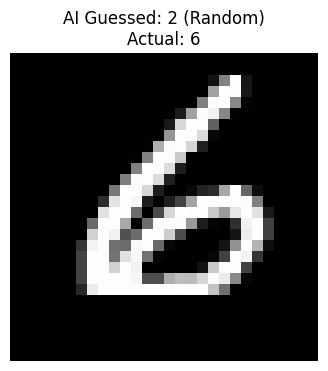

In [14]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==========================================
# 1. THE ARCHITECTURE
# ==========================================
class DistanceBiasedAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.distance_weight = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # Expects EXACTLY 3 dimensions: [Batch, SeqLen, Features]
        B, seq_len, _ = x.shape
        q, k, v = self.Q(x), self.K(x), self.V(x)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_model ** 0.5)
        
        indices = torch.arange(seq_len, device=x.device)
        distance_matrix = torch.abs(indices.unsqueeze(0) - indices.unsqueeze(1))
        scores = scores - (distance_matrix * self.distance_weight)
        
        attn_weights = torch.softmax(scores, dim=-1)
        return torch.matmul(attn_weights, v)

class FlexibleTransformer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_dim, 64) 
        self.attn1 = DistanceBiasedAttention(d_model=64)
        self.norm1 = nn.LayerNorm(64)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.norm1(x + self.attn1(x))
        x = x.mean(dim=1) 
        return self.classifier(x)

# ==========================================
# 2. LOAD ONE IMAGE AND TEST (FIXED)
# ==========================================
print("Loading one image for a quick test...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load standard MNIST without modifying internals
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True) 

# Initialize an "untrained" model
model = FlexibleTransformer(input_dim=1, num_classes=10)
model.eval()

# Grab one batch (which contains 1 image)
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get the true label
true_label = labels[0].item()

# -----------------------------------------------------
# THE FIX: Explicitly reshape the image to [1, 784, 1] 
# This guarantees exactly 3 dimensions for the Attention layer
# -----------------------------------------------------
flat_image = images.view(1, 784, 1)

# Get prediction
with torch.no_grad():
    output = model(flat_image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

# Plot the result
print("\nOpening image window...")
plt.figure(figsize=(4,4))
# Reshape the original image back to 28x28 just for plotting
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"AI Guessed: {predicted_label} (Random)\nActual: {true_label}")
plt.axis('off')
plt.show()

Loading one image for a quick test...

Opening image window...


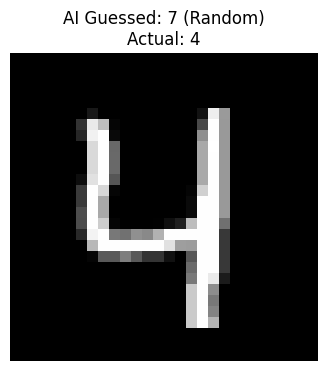

In [15]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==========================================
# 1. THE ARCHITECTURE
# ==========================================
class DistanceBiasedAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.distance_weight = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # Expects EXACTLY 3 dimensions: [Batch, SeqLen, Features]
        B, seq_len, _ = x.shape
        q, k, v = self.Q(x), self.K(x), self.V(x)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_model ** 0.5)
        
        indices = torch.arange(seq_len, device=x.device)
        distance_matrix = torch.abs(indices.unsqueeze(0) - indices.unsqueeze(1))
        scores = scores - (distance_matrix * self.distance_weight)
        
        attn_weights = torch.softmax(scores, dim=-1)
        return torch.matmul(attn_weights, v)

class FlexibleTransformer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_dim, 64) 
        self.attn1 = DistanceBiasedAttention(d_model=64)
        self.norm1 = nn.LayerNorm(64)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.norm1(x + self.attn1(x))
        x = x.mean(dim=1) 
        return self.classifier(x)

# ==========================================
# 2. LOAD ONE IMAGE AND TEST (FIXED)
# ==========================================
print("Loading one image for a quick test...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load standard MNIST without modifying internals
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True) 

# Initialize an "untrained" model
model = FlexibleTransformer(input_dim=1, num_classes=10)
model.eval()

# Grab one batch (which contains 1 image)
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get the true label
true_label = labels[0].item()

# -----------------------------------------------------
# THE FIX: Explicitly reshape the image to [1, 784, 1] 
# This guarantees exactly 3 dimensions for the Attention layer
# -----------------------------------------------------
flat_image = images.view(1, 784, 1)

# Get prediction
with torch.no_grad():
    output = model(flat_image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

# Plot the result
print("\nOpening image window...")
plt.figure(figsize=(4,4))
# Reshape the original image back to 28x28 just for plotting
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"AI Guessed: {predicted_label} (Random)\nActual: {true_label}")
plt.axis('off')
plt.show()

Loading one image for a quick test...

Opening image window...


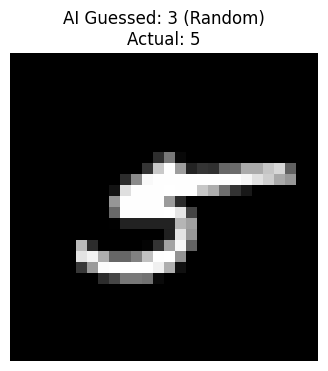

In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==========================================
# 1. THE ARCHITECTURE
# ==========================================
class DistanceBiasedAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.distance_weight = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        # Expects EXACTLY 3 dimensions: [Batch, SeqLen, Features]
        B, seq_len, _ = x.shape
        q, k, v = self.Q(x), self.K(x), self.V(x)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_model ** 0.5)
        
        indices = torch.arange(seq_len, device=x.device)
        distance_matrix = torch.abs(indices.unsqueeze(0) - indices.unsqueeze(1))
        scores = scores - (distance_matrix * self.distance_weight)
        
        attn_weights = torch.softmax(scores, dim=-1)
        return torch.matmul(attn_weights, v)

class FlexibleTransformer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_dim, 64) 
        self.attn1 = DistanceBiasedAttention(d_model=64)
        self.norm1 = nn.LayerNorm(64)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.norm1(x + self.attn1(x))
        x = x.mean(dim=1) 
        return self.classifier(x)

# ==========================================
# 2. LOAD ONE IMAGE AND TEST (FIXED)
# ==========================================
print("Loading one image for a quick test...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load standard MNIST without modifying internals
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True) 

# Initialize an "untrained" model
model = FlexibleTransformer(input_dim=1, num_classes=10)
model.eval()

# Grab one batch (which contains 1 image)
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get the true label
true_label = labels[0].item()

# -----------------------------------------------------
# THE FIX: Explicitly reshape the image to [1, 784, 1] 
# This guarantees exactly 3 dimensions for the Attention layer
# -----------------------------------------------------
flat_image = images.view(1, 784, 1)

# Get prediction
with torch.no_grad():
    output = model(flat_image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

# Plot the result
print("\nOpening image window...")
plt.figure(figsize=(4,4))
# Reshape the original image back to 28x28 just for plotting
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"AI Guessed: {predicted_label} (Random)\nActual: {true_label}")
plt.axis('off')
plt.show()